# ROSSMAN SALES PREDICTION

# 1. Problem Description

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 2. Imports and Helper Functions

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime
import missingno as msno

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute        import SimpleImputer
from sklearn.pipeline      import Pipeline, make_pipeline 
from sklearn.compose       import ColumnTransformer, TransformedTargetRegressor, make_column_transformer
from sklearn.linear_model  import LinearRegression

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

warnings.filterwarnings('ignore')

/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lucas1/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def mean_absolute_percentage_error(y, y_pred):
    return np.mean(np.abs((y - y_pred)/y))

    
def ml_error(model_name, y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt( mean_squared_error(y, y_pred))
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cross_validation(df, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold +1)):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = df['Date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = df['Date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        train = df[df['Date'] < validation_start_date]
        test = df[(df['Date'] >= validation_start_date) & (df['Date'] <= validation_end_date)]

        # train
        X_train = train.drop(['Customers', 'Sales'], axis=1)
        y_train = train['Sales']

        # validation
        X_test = test.drop(['Customers', 'Sales'], axis=1)
        y_test = test['Sales']

        # model
        m = model.fit(X_train, y_train)

        # prediction
        y_pred = m.predict(X_test)

        # performance
        m_result = ml_error(model_name, y_test, y_pred)

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def jupyter_settings():
    %matplotlib inline
    
    # plt.rcParams['figure.figsize'] = [25, 12]
    # plt.rcParams['font.size'] = 24
    
    # display(HTML('<style>.container { width:100% !important; }</style>'))
    # pd.options.display.max_columns = None
    # pd.options.display.max_rows = None
    # pd.set_option('display.expand_frame_repr', False)

    sns.set_theme()

In [3]:
jupyter_settings()

In [4]:
class TimeSeriesKFold:
    """ A cross-validation generator specifically created for time series 
    containing a 'Date' column with frequency in days.

    Provides train/test indices to split time series data samples in train/test
    sets. Samples can be observed at irregular time intervals.

    This cross-validation object is a variation of class 'KFold'.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set. Note that unlike standard cross-validation methods,
    successive training sets are supersets of those that come before them.

    It should be used inside a pipeline that drops the 'Date' column during 
    preprocessing.

    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.

    test_size : int, default=None
        Used to limit the size of the test set. Default is 42 days, or 6 weeks. 
        
    gap : int, default=0
        Number of DAYS to exclude from the end of each train set before
        the test set.
    """

    def __init__(self, n_splits=5, test_size=42, gap=0):
        self.n_splits = n_splits
        self.test_size = test_size
        self.gap = gap

    def split(self, X, y=None, groups=None):

        n_splits = self.n_splits
        n_folds = n_splits + 1
        test_size = self.test_size
        gap = self.gap

        X.index = np.arange(X.shape[0])

        for k in range(1, n_folds):

            test_start_date = X['Date'].max() - datetime.timedelta(days= k * test_size)
            test_end_date = X['Date'].max() - datetime.timedelta(days= (k-1) * test_size)

            train_end_date = test_start_date - datetime.timedelta(days=gap)

            train_index = X[X['Date'] < train_end_date].index.values
            test_index = X[(X['Date'] >= test_start_date) & (X['Date'] <= test_end_date)].index.values

            yield train_index, test_index

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

# 3. Data Preparation

## 3.1 Data Import

In [5]:
df_sales_raw = pd.read_csv('/Users/lucasstelmastchuk/Documents/repos/rossman_sales/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/Users/lucasstelmastchuk/Documents/repos/rossman_sales/data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

df = df_raw.copy()
df = df[df['Open'] == 1]
df = df[df['Sales'] > 0]
df['Date'] = pd.to_datetime(df['Date'])


print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
df.sample()

Number of rows: 844338
Number of columns: 18


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
523110,961,4,2014-03-20,5055,617,1,1,0,0,d,c,9430.0,NaN,NaN,0,NaN,NaN,NaN


## 3.2 Data Cleaning

<AxesSubplot:>

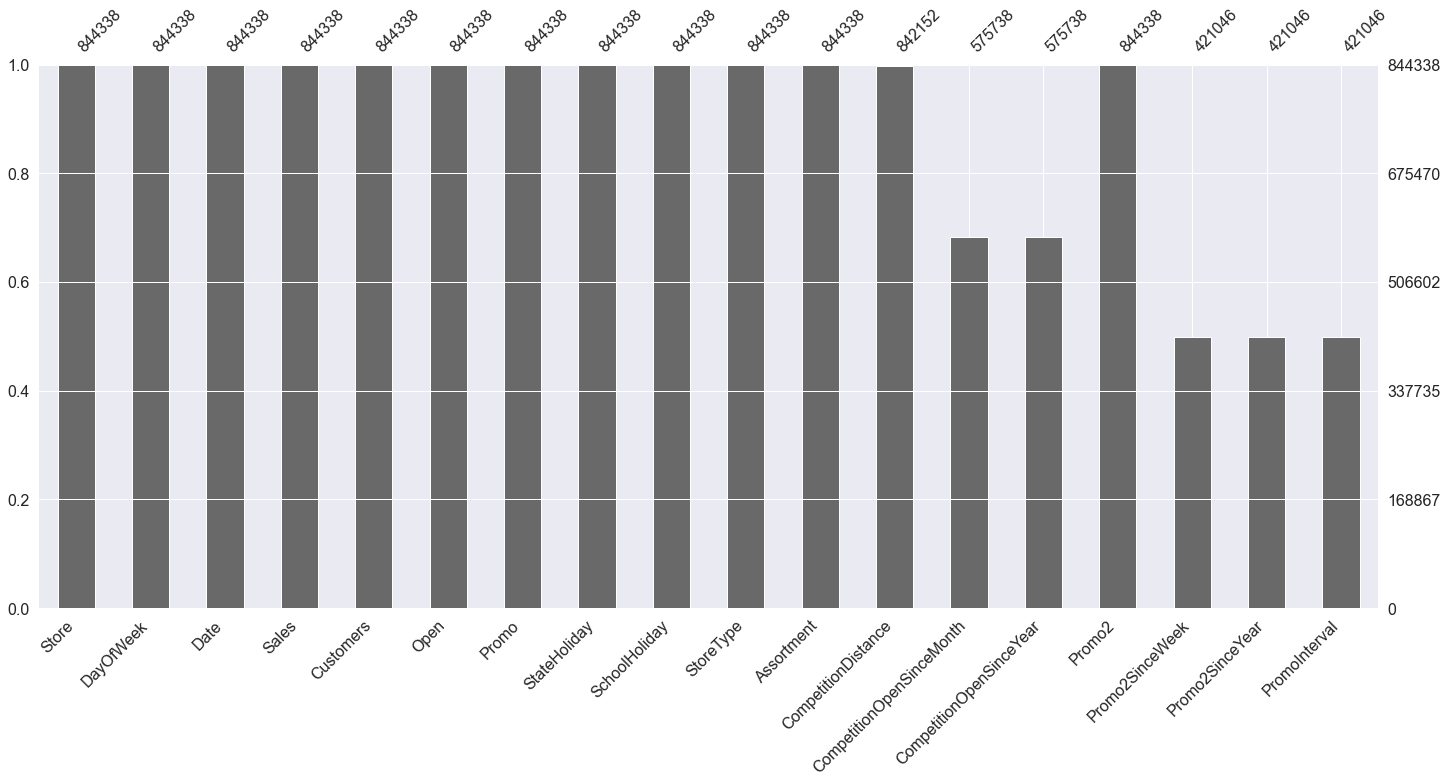

In [6]:
msno.bar(df)

<AxesSubplot:>

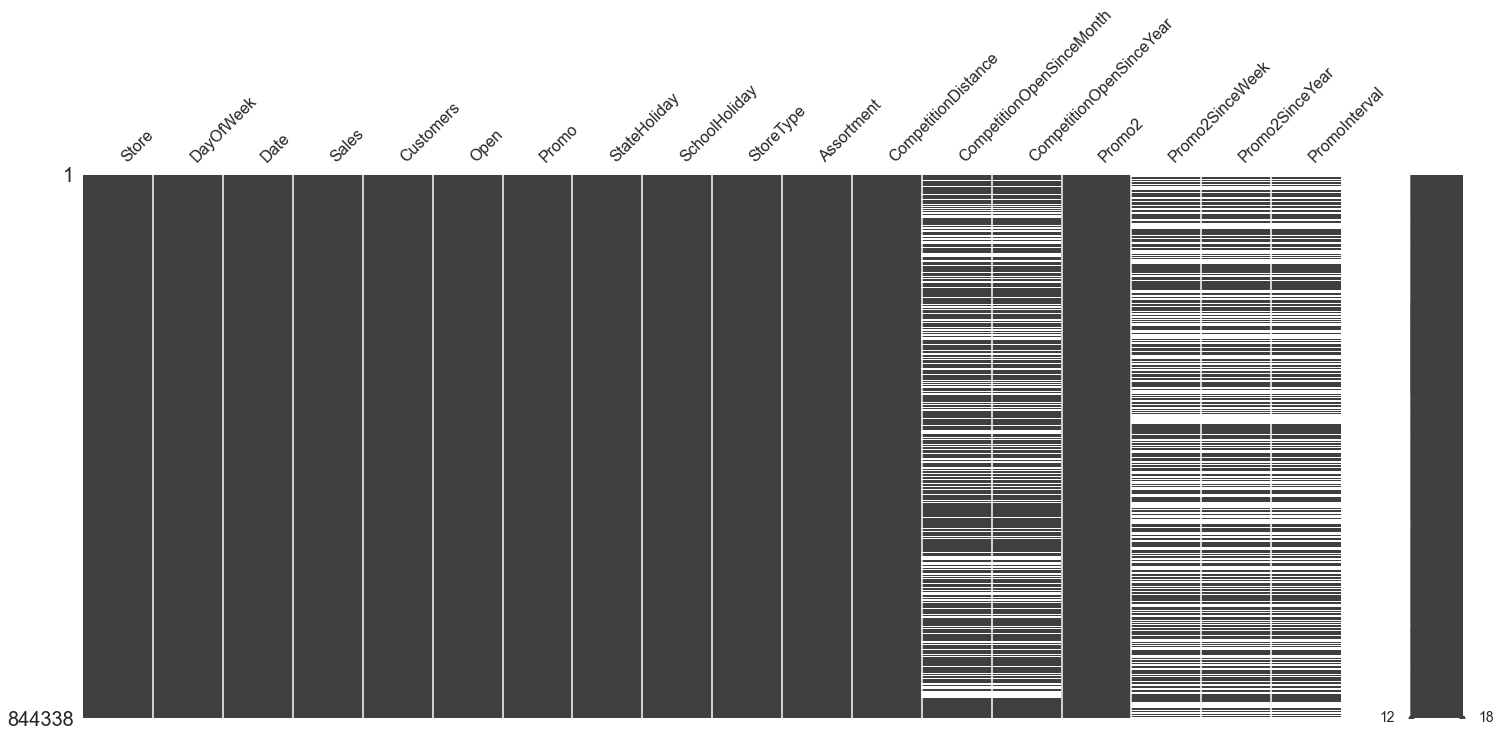

In [7]:
msno.matrix(df)

<AxesSubplot:>

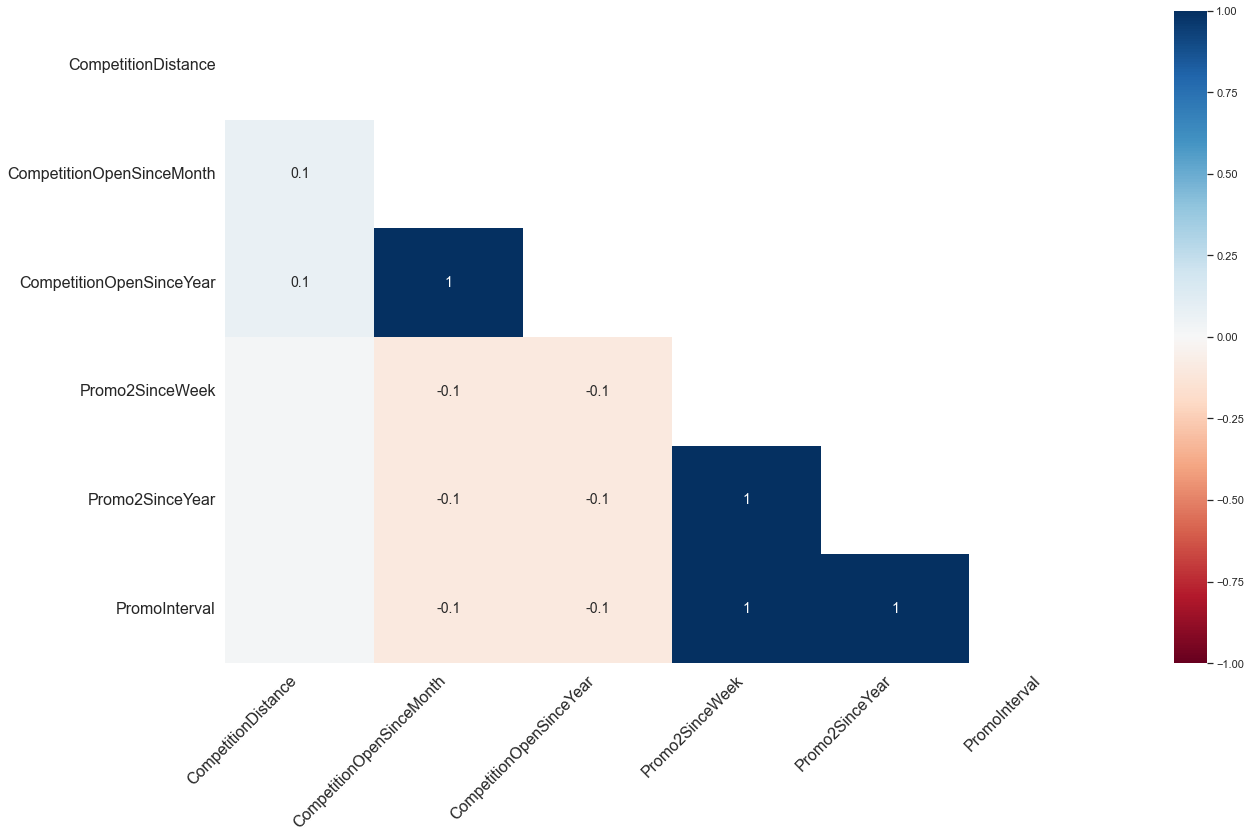

In [8]:
msno.heatmap(df)

In [10]:
def clean_df(df):

    # CHANGING COLUMN NAMES TO SNAKE_CASE
    cols_old = df.columns
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new

    # FILLING IN MISSING VALUES
    ## Maximum competition distance is 75,860 meters. Considering that missing values are probably related to stores with
    ## no competition nearby, these stores will get the value 200,000 meters to indicate that competitors are far away.      
    df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
    
    ## Imputation of the median competition opening month and year for stores with no information about competition opening date.
    ## Note that missing values here do not represent absence of competition, but absence of information about competition opening date,
    ## as competion distance have very few missing values.
    df['competition_open_since_month'] = SimpleImputer(strategy='median').fit_transform(df[['competition_open_since_month']])
    df['competition_open_since_year'] = SimpleImputer(strategy='median').fit_transform(df[['competition_open_since_year']])

    ## Missing values for start of promo2 are linked to stores that do not participate in this second type of promotion at any given year.
    ## Missing values will be replaced with the current date so that the total elapsed time for these stores since the start of the 
    ## promotion 2 will always be zero 0 (see feature engineering section).
    df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
    df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
   
    ## ENCODING CATEGORICAL FEATURES
    df['assortment'] = df['assortment'].map({'a': 1, 'b': 2, 'c': 3})
    df['state_holiday'] = df['state_holiday'].map({'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0': 'regular_day'})

    # CORRECTING DATA TYPES
    df['competition_open_since_month'] = df['competition_open_since_month'].astype(int)
    df['competition_open_since_year'] = df['competition_open_since_year'].astype(int)
    df['promo2_since_week'] = df['promo2_since_week'].astype(int)
    df['promo2_since_year'] = df['promo2_since_year'].astype(int)

    return df

clean_df_transformer = FunctionTransformer(clean_df)

In [11]:
df1 = clean_df_transformer.transform(df.drop(['Sales', 'Customers'], axis=1))
df1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,1,1,regular_day,1,c,1,1270.0,9,2008,0,31,2015,NaN
1,2,5,2015-07-31,1,1,regular_day,1,a,1,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,1,1,regular_day,1,a,1,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,1,1,regular_day,1,c,3,620.0,9,2009,0,31,2015,NaN
4,5,5,2015-07-31,1,1,regular_day,1,a,1,29910.0,4,2015,0,31,2015,NaN


# 4. Feature Engineering

In [14]:
def add_features(df):
    
    # Extract features from date
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day #day of month
    df['week_of_year'] = df['date'].dt.weekofyear
    df['is_weekend'] = df['date'].dt.weekday > 4
    df['is_weekend'] = df['is_weekend'].astype(int)

    # Combine year and month of competition opening and then calculate the elapsed time in months since competition opened.
    df['competition_since_date'] = df.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                        month=x['competition_open_since_month'],
                                                                        day=1), axis=1)
    df['months_since_competition_opened'] = ((df['date'] - df['competition_since_date'])/pd.Timedelta('30 days')).astype(int)
    df['months_since_competition_opened'] = df['months_since_competition_opened'].apply(lambda x: 0 if x < 0 else x)

    # promo since
    df['promo2_since_date'] = df['promo2_since_year'].astype(str) + '-' + df['promo2_since_week'].astype(str)
    df['promo2_since_date'] = df['promo2_since_date'].apply(lambda x: datetime.datetime.strptime(x + '-0', '%Y-%W-%w'))
    df['weeks_since_promo2_started'] = ((df['date'] - df['promo2_since_date'])/pd.Timedelta('7 days')).astype(int)
    df['weeks_since_promo2_started'] = df['weeks_since_promo2_started'].apply(lambda x: 0 if x < 0 else x)

    # promo interval
    def _transform_promo_interval(x):
        if x['promo_interval'] == 'Jan,Apr,Jul,Oct':
            if x['date'].month in [1, 4, 7, 10]:
                return 1
            elif x['date'].month in [2, 5, 8, 11]:
                return 2
            elif x['date'].month in [3, 6, 9, 12]:
                return 3
        elif x['promo_interval'] == 'Feb,May,Aug,Nov':
            if x['date'].month in [2, 5, 8, 11]:
                return 1
            elif x['date'].month in [3, 6, 9, 12]:
                return 2
            elif x['date'].month in [1, 4, 7, 10]:
                return 3
        elif x['promo_interval'] == 'Mar,Jun,Sept,Dec':
            if x['date'].month in [3, 6, 9, 12]:
                return 1
            elif x['date'].month in [1, 4, 7, 10]:
                return 2
            elif x['date'].month in [2, 5, 8, 11]:
                return 3
        else:
            return 0

    df['promo_interval'] = df[['date', 'promo_interval']].apply(lambda x: _transform_promo_interval(x), axis=1)

    # Drop unnecessary columns
    df.drop(['date', 'open', 'competition_open_since_month', 'competition_open_since_year', 
             'promo2_since_week', 'promo2_since_year', 'competition_since_date', 'promo2_since_date'], 
             axis=1, inplace=True)
    
    return df

add_features_transformer = FunctionTransformer(add_features)

In [15]:
df2 = add_features_transformer.transform(df1)
df2.head()

,store,day_of_week,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,promo2,promo_interval,month,day,week_of_year,is_weekend,months_since_competition_opened,weeks_since_promo2_started
0,1,5,1,regular_day,1,c,1,1270.0,0,0,7,31,31,0,84,0
1,2,5,1,regular_day,1,a,1,570.0,1,0,7,31,31,0,94,277
2,3,5,1,regular_day,1,a,1,14130.0,1,0,7,31,31,0,105,224
3,4,5,1,regular_day,1,c,3,620.0,0,0,7,31,31,0,71,0
4,5,5,1,regular_day,1,a,1,29910.0,0,0,7,31,31,0,4,0


In [16]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x * (2 * np.pi/period)), feature_names_out='one-to-one')

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x * (2 * np.pi/period)), feature_names_out='one-to-one')

In [17]:
column_transformer = ColumnTransformer(
    transformers=[
        ('passthrough', 'passthrough', ['store', 'promo', 'assortment', 'school_holiday', 'promo2', 'promo_interval', 'is_weekend']),
        ("categorical_encoding", OneHotEncoder(sparse=False), ['store_type', 'state_holiday']),
        ("day_of_week_sin", sin_transformer(7), ['day_of_week']),
        ("day_of_week_cos", cos_transformer(7), ['day_of_week']),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("day_of_month_sin", sin_transformer(30), ['day']),
        ("day_of_month_cos", cos_transformer(30), ['day']),
        ("week_of_year_sin", sin_transformer(52), ['week_of_year']),
        ("week_of_year_cos", cos_transformer(52), ['week_of_year']),
        ("num_scaling", RobustScaler(), ['competition_distance', 'months_since_competition_opened', 'weeks_since_promo2_started'])
    ],
    remainder='drop')

## FEATURE SELECTION

# 7. Machine Learning Models

### Linear Regression

In [19]:
# model
lr = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1) 
lr_pipeline = make_pipeline(clean_df_transformer, add_features_transformer, column_transformer, lr)

# performance
lr_result_cv = cross_validation(df, 5, 'LinearRegression', lr_pipeline, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,1913.36 +/- 121.44,0.29 +/- 0.01,2717.7 +/- 213.95


In [23]:
scores = cross_val_score(lr_pipeline, df, df['Sales'], scoring='neg_root_mean_squared_error', cv=TimeSeriesKFold(n_splits=5))

In [24]:
scores.mean()

-2717.704781669479

In [ ]:
X = df[['Date', 'Customers']]
y = df['Sales']

In [ ]:
ct = make_column_transformer(
         ('drop', ['Date']),
         ('passthrough', ['Customers']))

model = LinearRegression()

In [ ]:
pipe = make_pipeline(ct, model)
pipe

In [ ]:
pipe[0].fit_transform(X)

In [ ]:
cross_val_score(pipe, X, y, cv=TimeSeriesKFold(n_splits=5, test_size=100, gap=200))

In [ ]:
train_indeces = []
test_indeces = []

for train_index, test_index in TimeSeriesKFold(n_splits=5, test_size=42).split(X):
    train_indeces.append(train_index)
    test_indeces.append(test_index)

In [ ]:
train_indeces

In [ ]:
test_indeces

In [ ]:
myCViterator = []
for i in TimeSeriesKFold(n_splits=5, test_size=42).split(X):
    myCViterator.append(i)

myCViterator

### Lasso

In [ ]:
# model
lrr = Lasso(alpha=0.01)
tlrr = TransformedTargetRegressor(lrr, func=np.log1p, inverse_func=np.expm1) 
lrr_pipeline = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, tlrr)

# performance
lrr_result_cv = cross_validation(df, 5, 'Lasso', tlrr_pipeline, verbose=False )
lrr_result_cv

### Random Forest

In [ ]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
trf = TransformedTargetRegressor(rf, func=np.log1p, inverse_func=np.expm1) 
trf_pipeline = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, trf)

# performance
rf_result_cv = cross_validation(df, 5, 'Random Forest', trf_pipeline, verbose=False)
rf_result_cv

In [ ]:
trf_pipeline[-1]

### XGBoost

In [ ]:
# model
xgb_regressor = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=1000, 
                                  eta=0.01, 
                                  max_depth=10, 
                                  subsample=0.7,
                                  colsample_bytree=0.9 )
t_xgb_regressor = TransformedTargetRegressor(xgb_regressor, func=np.log1p, inverse_func=np.expm1) 
xgb_pipeline = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, t_xgb_regressor)

# performance
xgb_result_cv = cross_validation(df, 5, 'XGBoost', xgb_pipeline, verbose=False)
xgb_result_cv

### Model Performance Comparison

In [ ]:
models_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
models_result_cv

### Hyperparameter Fine Tuning

In [ ]:
param = {
   'n_estimators': [1500, 1700, 2500, 3000, 3500],
   'eta': [0.01, 0.03],
   'max_depth': [3, 5, 9],
   'subsample': [0.1, 0.5, 0.7],
   'colsample_bytree': [0.3, 0.7, 0.9],
   'min_child_weight': [3, 8, 15]
       }

MAX_EVAL = 10

In [ ]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
   # choose values for parameters randomly
   hp = {k:random.sample(v,1)[0] for k, v in param.items()}
   print(hp)
   
   # model
   model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'] )
   transformed_xgb_regressor = TransformedTargetRegressor(model_xgb, func=np.log1p, inverse_func=np.expm1) 
   xgb_pipeline_tuning = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, transformed_xgb_regressor)
   
   # performance
   result = cross_validation(df, 5, 'XGBoost Regressor', xgb_pipeline_tuning, verbose=False)
   final_result = pd.concat([final_result, result])
       
final_result

### Final Model

In [ ]:
param_tuned = {
    'n_estimators': 1700,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'min_child_weight': 8 
        }

In [ ]:
# model
xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'])
model_xgb_tuned = TransformedTargetRegressor(xgb_tuned, func=np.log1p, inverse_func=np.expm1) 
xgb_pipeline_tuned = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, model_xgb_tuned)

## Error Interpretation

In [ ]:
train = df[df['Date'] < '2015-06-19']
test = df[df['Date'] >= '2015-06-19']

# train
X_train = train.drop(['Customers', 'Sales'], axis=1)
y_train = train['Sales']

# validation
X_test = test.drop(['Customers', 'Sales'], axis=1)
y_test = test['Sales']

In [ ]:
xgb_pipeline_tuned.fit(X_train, y_train)

In [ ]:
y_pred = xgb_pipeline_tuned.predict(X_test)

xgb_result_tuned = ml_error('XGBoost Regressor', y_test, y_pred)
xgb_result_tuned

In [ ]:
sales_predictions_next_six_weeks = pd.DataFrame({'store':X_test['store'], 'sales':y_test, 'sales_prediction':y_pred})
total_sales_predictions_per_store = sales_predictions_next_six_weeks.groupby('store').sum()
mae = sales_predictions_next_six_weeks.groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['sales_prediction'])).reset_index().rename(columns={0:'MAE'})
mape = sales_predictions_next_six_weeks.groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['sales_prediction'])).reset_index().rename(columns={0:'MAPE'})

# Merge
aux1 = pd.merge(mae, mape, how='inner', on='store')
aux2 = pd.merge(aux1, total_sales_predictions_per_store, how='inner', on='store')

plt.subplot(1,2,1)
sns.scatterplot(x='store', y='MAPE', data=aux2)

plt.subplot(1,2,2)
sns.scatterplot(x='store', y='MAE', data=aux2)

### Total Performance

In [ ]:
total_sales_prediction = sales_predictions_next_six_weeks['sales_prediction'].sum()
best_scenario = total_sales_prediction + xgb_result_tuned['MAE'].values[0]
worst_scenario = total_sales_prediction - xgb_result_tuned['MAE'].values[0]

scenarios = pd.DataFrame({'Scenario':['Total Sales Prediction', 'Worst Scenario', 'Best Scenario'],
                'Value':[total_sales_prediction, worst_scenario, best_scenario]})

scenarios['Value'] = scenarios['Value'].map('R${:,.2f}'.format)
scenarios

### Machine Learning Performance

In [ ]:
df_results = pd.DataFrame({'date':X_test['date'], 'store':X_test['store'], 'sales':y_test, 'sales_prediction':y_pred})
df_results['residual'] = df_results['sales'] - df_results['sales_prediction']
df_results['error_rate'] = df_results['sales_prediction']/df_results['sales']
df_results.head()

In [ ]:
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df_results, label='SALES')
sns.lineplot( x='date', y='sales_prediction', data=df_results, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df_results)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df_results['residual'])

plt.subplot(2, 2, 4)
sns.scatterplot(df_results['sales_prediction'], df_results['residual'])

# Kaggle Submission